### Notes before we start

We want to create a plotting utility so we can easily plot and compare different matrices. We might move them to `hicstuff.py` for import, but as for now, they are defined only in this notebook.

## Setup

### Imports for plots etc

In [2]:
# import standard python libraries
import numpy as np
import pandas as pd

# Import packages for working with cooler files and tools for plots
import cooler
import cooltools.lib.plotting
import cooltools
import seaborn as sns
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable



### `InlineBackend.rc`

For consistent plots that fit with pdf manus.

In [10]:
import matplotlib.pyplot as plt


In [17]:

# Define my params:
## Params will comply with my desired layout for the Manuscript (PDF)

notebook_rcparams = {
    'font.size': 7,
    'axes.titlesize': 8,
    'axes.labelsize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'figure.titlesize': 9,
    'figure.figsize': [6.0, 2.0],
    'figure.labelsize': 7
    
}

# Set output to be retina:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.rc = notebook_rcparams


### Load all the coolers and eigenvectors

In [18]:
## Loading all coolers and their compartments
import glob
import os.path as op
import cooler

# Abbreviate the names (almost the same abbreviations as Wang et al. 2019)
names_abbr = {'fibroblast': 'Fib', 'spermatogonia': 'SPA', 'pachytene_spermatocyte': 'PAC', 'round_spermatid': 'RS', 'sperm': 'Sp'}

# Paths and resolutions
mcools = pd.Series(glob.glob("../steps/bwa/*/cool/*/*.mcool"))
res_100 = "::resolutions/100000"
res_500 = "::resolutions/500000"

# Create a DataFrame
clr_df = pd.DataFrame({
    'name': pd.concat([mcools.apply(lambda x: op.basename(op.dirname(x)))] * 3, ignore_index=True),
    'resolution': ['100'] * len(mcools) + ['ps500'] * len(mcools) + ['500'] * len(mcools),
    'mcool_path': pd.concat([mcools] * 3, ignore_index=True)
})

# Insert the 'sname' column (shortname/abbreviation) 
clr_df['sname'] = clr_df['name'].apply(lambda x: names_abbr[x])

# Create the 'cooler_id' column
clr_df['cooler_id'] = clr_df.apply(
    lambda row: cooler.Cooler(
        row['mcool_path'] + (res_100 if row['resolution'] in ['100', 'ps500'] else res_500)
        ),
    axis=1
)

# Determine parsing run (dirname 3 levels up PE or recPE)
clr_df['run'] = clr_df['mcool_path'].apply(lambda x: 'recPE' if 'rec' in x else 'PE')

# Add the 'nbins' column
clr_df['nbins'] = clr_df['cooler_id'].apply(lambda x: len(x.bins().fetch('chrX')))

# Add the path to the compartments (../results/{compartments,rec_compartments})
# make a comp_dir dict
comp_dirs = {
    'PE': '../results/compartments/',
    'recPE': '../results/rec_compartments/'
}

clr_df['e1_path'] = clr_df.apply(
    lambda row: {view: pd.read_csv(op.join(
        comp_dirs[row['run']], f"{row['name']}_e1_{row['resolution']}kb_{view}.csv"
        ))['e1']
        if row['resolution'] != 'ps500' 
        else  pd.read_csv(op.join(
        comp_dirs[row['run']], f"{row['name']}_e1_100kb_{view}_smoothed.csv"
        ))['e1'] 
        for view in ['full', 'arms', '10Mb']},
    axis=1
)

# Now we have all the coolers and compartments ready for plotting (in semi-long format)
#clr_df
clr_df[['sname', 'resolution', 'nbins', 'run', 'e1_path']].query('resolution == "ps500"')
#print(clr_df['e1_path'].values)

,sname,resolution,nbins,run,e1_path
10,PAC,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
11,SPA,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
12,Fib,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, -0.15077432..."
13,RS,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, nan, nan, n..."
14,Sp,ps500,1534,recPE,"{'full': [nan, nan, nan, nan, nan, -0.00698684..."
15,RS,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, -0.17383142..."
16,SPA,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, nan, nan, -..."
17,Sp,ps500,1534,PE,"{'full': [nan, nan, nan, -0.102536873416233, -..."
18,Fib,ps500,1534,PE,"{'full': [nan, nan, nan, -0.2342462339281897, ..."
19,PAC,ps500,1534,PE,"{'full': [nan, nan, nan, nan, nan, 0.595328434..."


## Define a plotting utility

In [19]:
# Converting the above code into a function
# We want to have the opportunity to vary the number of subplots based on the number of coolers
# We will also want to have the opportunity to vary the number of views for each cooler
# We will want to define the region of the chromosome to plot (default chrX)

def plot_matrices_and_compartments(
    group: pd.DataFrame, 
    region: str = 'chrX',
    include_compartments: bool = True,
    view_order: list[str] = ['10Mb', 'arms', 'full'], 
    figsize: tuple[float, float] = (6, 6),
) -> None:
    
    group = group.reset_index(drop=True)
    
    # Define the number of subplots based on the number of coolers
    f, axs = plt.subplots(1,group.shape[0],
        figsize=figsize, 
        sharex=True
    )

    # Logtransform the colorscale
    norm = LogNorm(vmax=0.1)

    # If there is only one cooler, axs is not a list, so we need to make it a list
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    
    # Loop through the clrs and its matrix: plot the matrix on its axis
    for row in group.itertuples():
        ax = axs[row.Index]
        # Define the y-axis label
        title = f'{row.sname}{row.resolution}kb: {row.run}'
        ylab = f'{region}:{row.resolution}kb [Mb]'

        # Extract some variables
        e1_dict = {k: v for k, v in row.e1_path.items() if k in view_order}
        chrom_start = row.cooler_id.bins().fetch(region)['start'].values
        chrom_end = row.cooler_id.bins().fetch(region)['end'].values

        im = ax.matshow(
            row.cooler_id.matrix().fetch(region),
            norm=norm,
            cmap='fall',
        );
        ax.set_xlim(0, row.nbins)
        ax.set_ylim(row.nbins, 0)
        ax.set_ylabel(ylab)
        ticks = np.linspace(0, row.nbins, 5)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{x*row.cooler_id.binsize/1_000_000:.0f}' for x in ticks])
        ax.xaxis.set_visible(False)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        plt.colorbar(im, cax=cax, label='corrected frequencies');
        # Only show the colorbar on the last plot and ytitle on first plot
        if row.Index != group.shape[0] - 1:
            cax.set_visible(False)
        elif row.Index != 0:
            ax.set_ylabel('')

        # Skip the E1 plot when
        if not include_compartments:
            ax.set_title(title)
            continue

        for j, (view, e1) in enumerate(e1_dict.items()):
            ax1 = divider.append_axes("top", size="10%", pad=0.1, sharex = ax)

            # Create stairs
            x = np.zeros(2*chrom_start.size)
            y = np.zeros(2*chrom_start.size)
            x[0::2] = chrom_start/row.cooler_id.binsize
            x[1::2] = chrom_end/row.cooler_id.binsize
            y[0::2] = e1
            y[1::2] = e1

            ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red', ec = 'None')
            ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue', ec = 'None')

            ax1.set_ylabel(view, rotation=0, ha='right', va='center')
            ax1.set_ylim(-0.8, 0.8)
            ax1.set_yticks([])
            ax1.set_xticks([])
            ax1.spines[:].set_visible(False)

        ax1.set_title(title)
    f.set_layout_engine('compressed')
    plt.show()
    





### PE vs recPE (RS100kb)

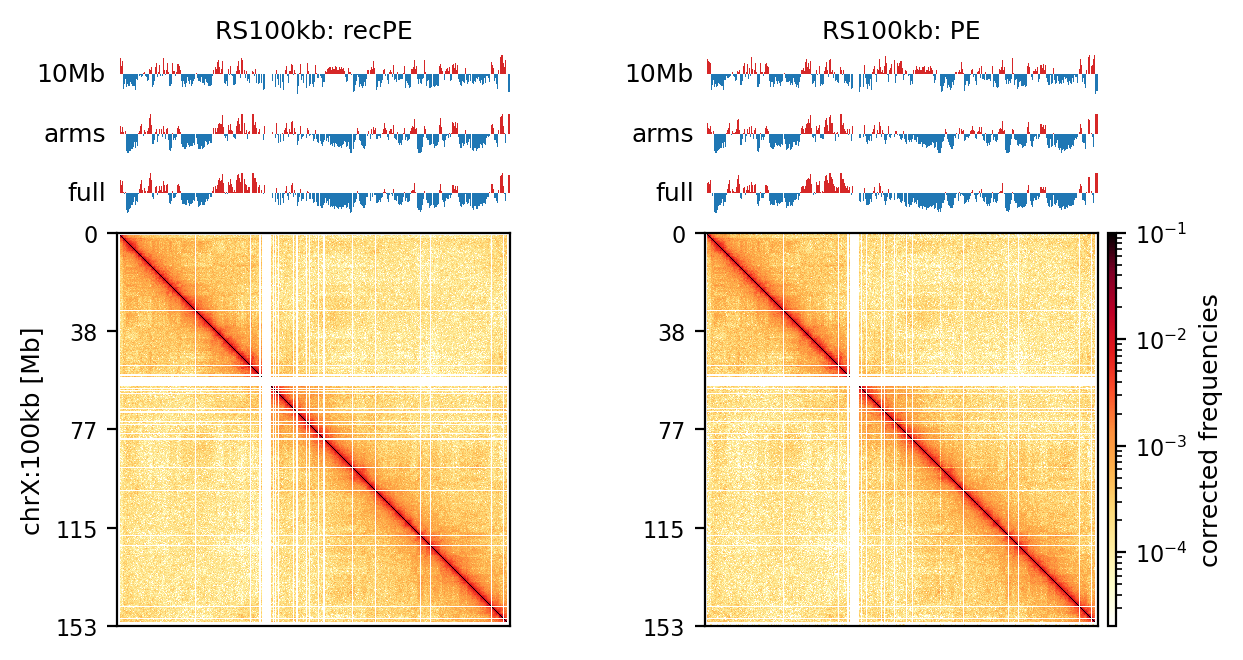

In [20]:
# Compare PE and recPE compartments for round_spermatid, 100kb

group = clr_df.query('resolution == "100" and name == "round_spermatid"')

plot_matrices_and_compartments(group, figsize=(6, 6))

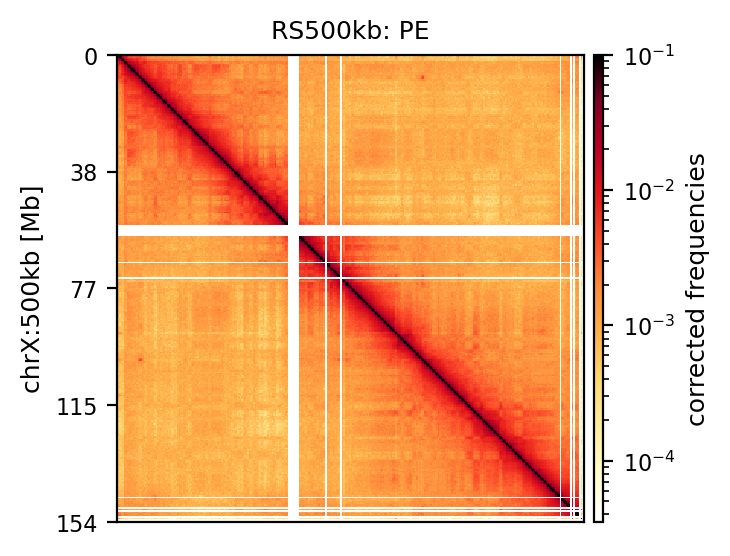

In [21]:
df = clr_df.query('resolution == "500" and name == "round_spermatid" and run == "PE"')

plot_matrices_and_compartments(df, include_compartments=False, figsize=(3, 3))

## Plotting 2

Plotting function that makes separate plots in stead of mpl.subplots. This makes it compatible with YAML header subfigures and layout options for embedding into Quarto

In [180]:
def plot_separate(
    group: pd.DataFrame, 
    region: str | tuple[str, int, int] = 'chrX',
    include_compartments: bool = True,
    view_order: list[str] = ['10Mb', 'arms', 'full'], 
    figsize: tuple[float, float] = (6, 6),
) -> None:
    """
    Plot each cooler as a separate figure to allow Quarto YAML options for subfigure plots.
    """
    group = group.reset_index(drop=True)

    # Scale figsize based on the number of coolers
    figsize = (figsize[0]/group.shape[0], figsize[1])

    # Set the region to a tuple if it is a string
    if isinstance(region, str):
        region = (region, 0, group.iloc[0].cooler_id.chromsizes[region])
    
    # Define start and end for the matrix plot
    start, end = region[1], region[2]

    # Loop through each cooler (row) in the DataFrame
    for row in group.itertuples():
        # Create a new figure for each cooler
        # Scale figsize
        fig, ax = plt.subplots(figsize=figsize)

        # Logtransform the colorscale
        norm = LogNorm(vmax=0.1)

        # Define the y-axis label
        # title = f'{row.sname}{row.resolution}kb: {row.run}'
        ylab = f'{row.resolution}kb'

        # Extract some variables
        e1_dict = {k: row.e1_path[k] for k in view_order}
        chrom_start = row.cooler_id.bins().fetch(region)['start'].values
        chrom_end = row.cooler_id.bins().fetch(region)['end'].values
        nbins = chrom_start.size # != row.nbins when subsetting chr
        binsize = row.cooler_id.binsize # is used several times

        # Plot the Hi-C matrix
        im = ax.matshow(
            row.cooler_id.matrix().fetch(region),
            norm=norm,
            cmap='fall',
            extent=(0, nbins, nbins, 0)
        )
        ax.set_xlim(0, nbins)
        ax.set_ylim(nbins, 0)
        ax.set_ylabel(ylab)
        ticks = np.linspace(0, nbins, 5)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{(start/binsize+x)*binsize/1_000_000:.0f}' for x in ticks])
        ax.xaxis.set_visible(False)

        # Add a colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        plt.colorbar(im, cax=cax, label='corrected frequencies')

        # Skip E1 plot if not including compartments
        if include_compartments:
            for view, e1 in e1_dict.items():
                # subset the e1 to region (chrX:start-end)/binsize
                start_bin = int(chrom_start[0]/binsize)
                end_bin = int(chrom_start[-1]/binsize)
                e1 = e1.iloc[start_bin:end_bin+1].reset_index(drop=True)
                ax1 = divider.append_axes("top", size="10%", pad=0.05, sharex=ax)

                # Create stairs for E1 values
                x = np.zeros(2 * chrom_start.size)
                y = np.zeros(2 * chrom_start.size)
                x[0::2] = np.arange(chrom_start.size)
                x[1::2] = np.arange(chrom_start.size)
                y[0::2] = e1
                y[1::2] = e1

                ax1.fill_between(x, y, 0, where=(y > 0), color='tab:red', ec='None')
                ax1.fill_between(x, y, 0, where=(y < 0), color='tab:blue', ec='None')

                if len(e1_dict) > 1:
                    ax1.set_ylabel(view, rotation=0, ha='right', va='center', fontsize=7)
                else:
                    ax1.set_ylabel('E1', rotation=0, ha='right', va='center', fontsize=7)

                ax1.set_ylim(-0.8, 0.8)
                ax1.set_yticks([])
                ax1.set_xticks([])
                ax1.spines[:].set_visible(False)

        # # Set the figure title
            # ax1.set_title(title)
        
        fig.tight_layout()

        # Display the figure for Quarto to capture
        plt.show()


### PE vs. recPE: RS100kb

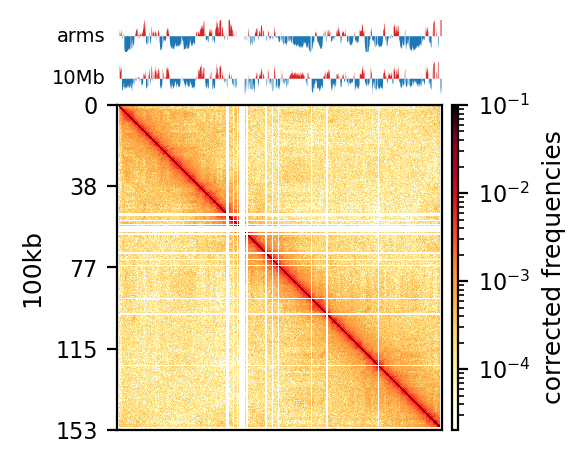

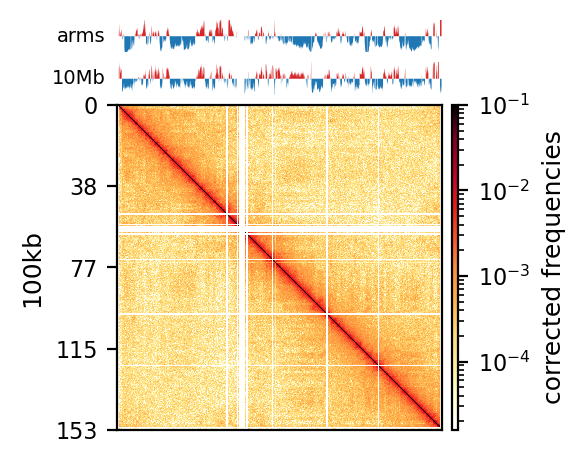

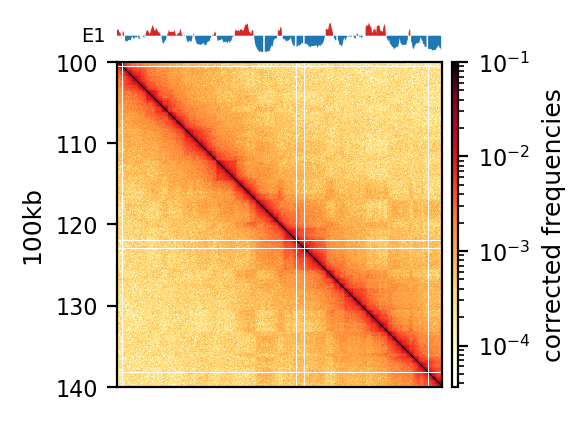

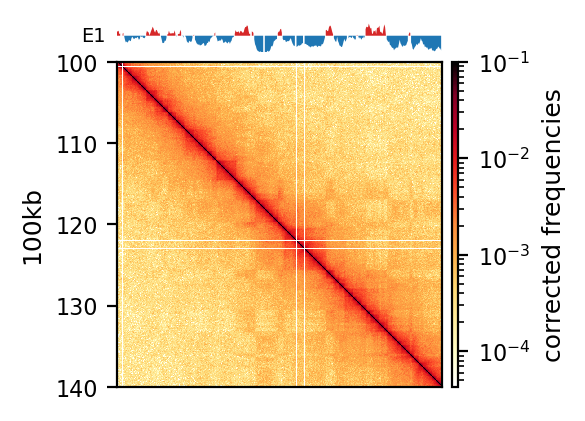

In [183]:
#| label: fig-rs100-recpe-pe
#| fig-cap: "Comparing two Hi-C matrices"
#| fig-subcap:
#|   - "recPE RS 100kb full chrX"
#|   - "PE RS 100kb full chrX"
#|   - "recPE RS 100kb chrX:100Mb-140Mb"
#|   - "PE RS 100kb chrX:100Mb-140Mb"
#| layout: [[-0.05,1,1,-0.05],[-0.05,1,1,-0.05]]

df = clr_df.query('resolution == "100" and name == "round_spermatid"')

# Check the order of the group
#print(df[['name', 'resolution', 'run']].reset_index(drop=True))

plot_separate(df, view_order=['10Mb','arms'], figsize=(6, 6))

start, end = 100_000_000, 140_000_000
region = ('chrX', start, end)
plot_separate(df, region=region, include_compartments=True, view_order=['arms'], figsize=(6, 6))